In [1]:
using ITensors
import TensorCrossInterpolation as TCI
using TCIITensorConversion
using QuanticsGrids
using Plots
include("../../src/functions.jl")

packages uploaded
------------------------------


functions uploaded
------------------------------


In [2]:

function fermionic_ν(s::Vector{Int}, β::Real, L::Int64)
    x = b2c(s)  # Convert binary vector `s` to a scalar value `x`
    n = 2^(L + 1) * (x - 1/2)  # Calculate n based on `x` and `L`
    iν = (π/β) * (2*n + 1) * im  # Compute the imaginary part (fermionic frequency)
    return iν  # Return the fermionic frequency as a complex number
end




fermionic_ν (generic function with 1 method)

**Part I**

In [13]:
Es = range(-1, 1, length=100)  # Correct range creation
L = 30
β = 100
χs = []
nFs = Vector{ComplexF64}(undef, length(Es))  # Initialize to store complex numbers





result, time, memory, allocations = @timed begin
    for i in 1:length(Es)
        sleep(0.01)
        E = Es[i]

        ϵ = 10^(-4)
        f(v) = (2 / β) * exp(fermionic_ν(v, β, L) * ϵ) / (fermionic_ν(v, β, L) - E)

        localdims = fill(2, L)  # Fill the tensor with dimensions of size 2

        tolerance = 1e-8

        tci, ranks, errors = TCI.crossinterpolate2(ComplexF64, f, localdims; tolerance=tolerance)

        mps = MPS(tci)

        χ = [d for d in linkdims(mps)]
        push!(χs, χ)

        nFs[i] = 2^(L)*integrate(mps)
        if i%10 ==0
            println('-'^20)
            println(i)
        end
    end
end

# Output the timing and memory details
println("Time: ", time, " seconds")
println("Memory: ", memory, " bytes")
println("Allocations: ", allocations)


--------------------
10


--------------------
20


--------------------
30


--------------------
40


--------------------
50


--------------------
60


--------------------
70


--------------------
80


--------------------
90


--------------------
100
Time: 16.665202083 seconds
Memory: 4490767792 bytes
Allocations: 0.579162084


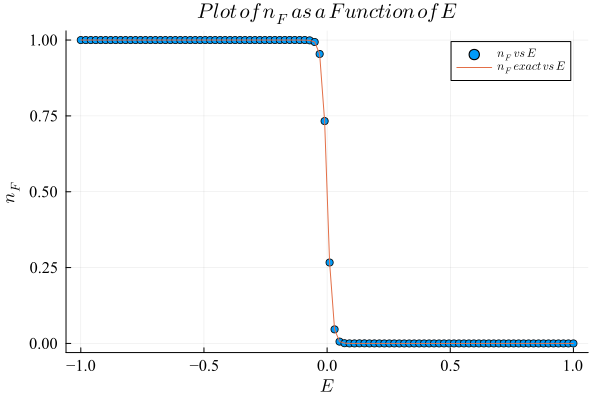

In [14]:
using Plots
using LaTeXStrings

# Set default font family (Times New Roman) and apply individual font sizes
default(fontfamily="Times New Roman")

# Define the function nF_exact
function nF_exact(β0, E)
    return 1 / (1 + exp(β0 * E))
end


scatter(Es, real.(nFs), label=L"n_F \, \textit{vs} \, E", xlabel=L"E", ylabel=L"n_F", 
    title=L"Plot \, of \, n_F \, \textit{as} \, a \, \textit{Function} \, of \, E", 
    legend=:topright, grid=true,
    titlefont=14, guidefont=12, tickfont=10)  # Set fonts for title, axis labels, and ticks

# Overlay the exact function plot
plot!(Es, nF_exact.(β, Es), label=L"n_F \, \textit{exact} \, \textit{vs} \, E", 
    legend=:topright,
    titlefont=14, guidefont=12, tickfont=10)

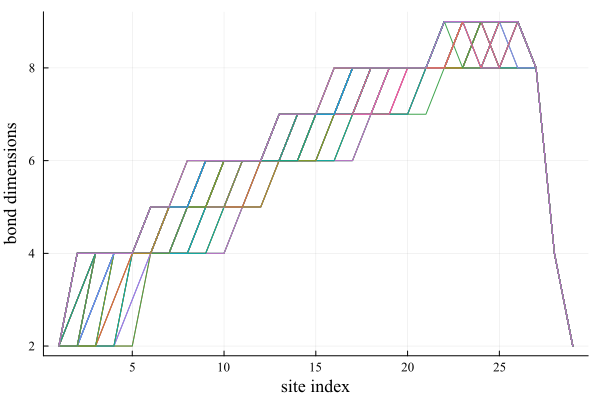

In [15]:
plot(χs, xlabel = "site index", ylabel = "bond dimensions",legend=false)

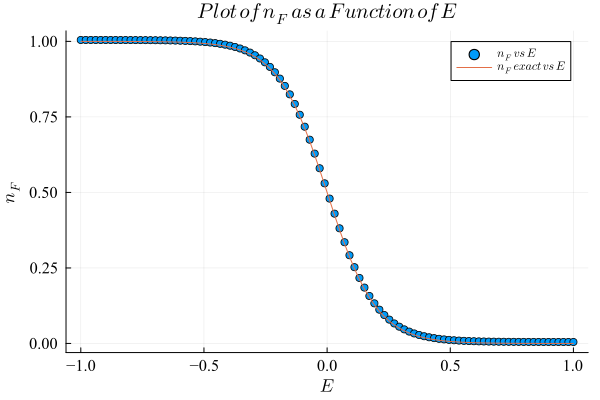

Time: 9.117595084 seconds
Memory: 2972923480 bytes
Allocations: 0.447276458


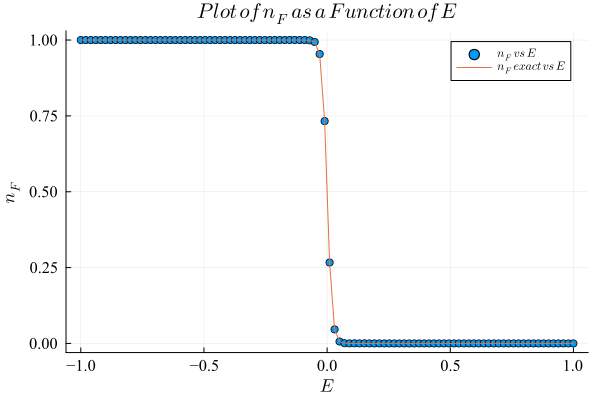

Time: 13.752864584 seconds
Memory: 4392479584 bytes
Allocations: 0.504163461


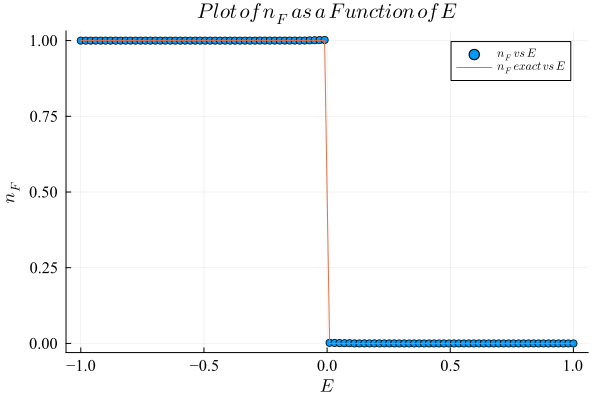

Time: 18.925533958 seconds
Memory: 5467432224 bytes
Allocations: 0.650031503


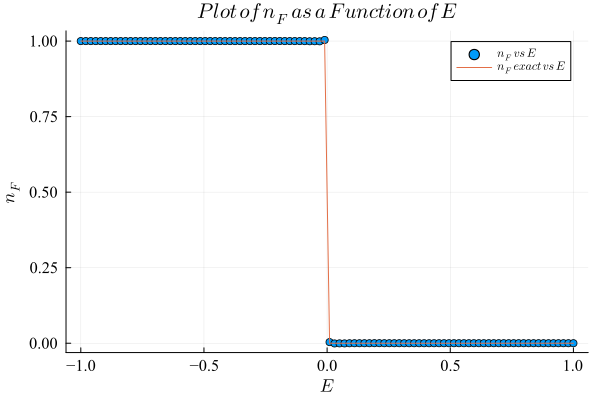

Time: 23.841856291 seconds
Memory: 6753004112 bytes
Allocations: 0.759913961


In [16]:
betas = [10,100,1000,10000]
cal_times = []

for beta in betas 
    Es = range(-1, 1, length=100)  # Correct range creation
    L = Int(round(10*log10(beta))) + 10
    β = beta
    χs = []
    nFs = Vector{ComplexF64}(undef, length(Es))  # Initialize to store complex numbers


    result, time, memory, allocations = @timed begin
        for i in 1:length(Es)
            sleep(0.01)
            E = Es[i]

            ϵ = 10^(-4)
            f(v) = (2 / β) * exp(fermionic_ν(v, β, L) * ϵ) / (fermionic_ν(v, β, L) - E)

            localdims = fill(2, L)  # Fill the tensor with dimensions of size 2

            tolerance = 1e-8

            tci, ranks, errors = TCI.crossinterpolate2(ComplexF64, f, localdims; tolerance=tolerance)

            mps = MPS(tci)

            χ = [d for d in linkdims(mps)]
            push!(χs, χ)

            nFs[i] = 2^(L)*integrate(mps)
            #if i%10 ==0
            #    println('-'^20)
            #    println(i)
            #end
        end
    end

    p = scatter(Es, real.(nFs), label=L"n_F \, \textit{vs} \, E", xlabel=L"E", ylabel=L"n_F", 
    title=L"Plot \, of \, n_F \, \textit{as} \, a \, \textit{Function} \, of \, E", 
    legend=:topright, grid=true,
    titlefont=14, guidefont=12, tickfont=10)  # Set fonts for title, axis labels, and ticks

    # Overlay the exact function plot
    plot!(Es, nF_exact.(β, Es), label=L"n_F \, \textit{exact} \, \textit{vs} \, E", 
        legend=:topright,
        titlefont=14, guidefont=12, tickfont=10)
    display(p)

    # Output the timing and memory details
    println("Time: ", time, " seconds")
    println("Memory: ", memory, " bytes")
    println("Allocations: ", allocations)
    push!(cal_times,time)
end

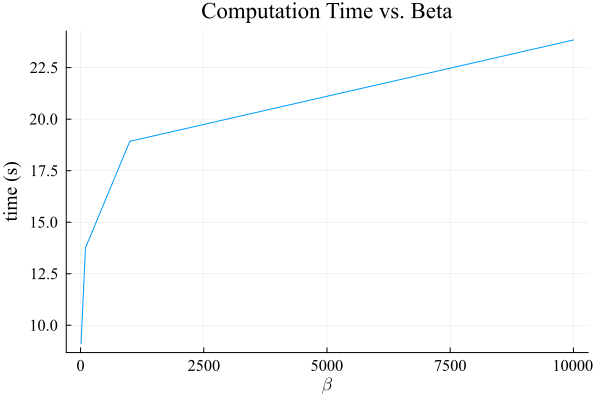

In [17]:
plot(betas, cal_times, xlabel=L"\beta", ylabel="time (s)", legend=false, 
     title="Computation Time vs. Beta", titlefont=14, guidefont=12, tickfont=10)

**New way of calculating using the partial Integral** 

**Part II**

In [63]:


L1 = 40 #for n
L2 = 10 #for E
L3 = 10
L = Int(L1+L2+L3)
β_max = 1000
E_max = 5

η = 10^(-3)

G(iω, E) = exp(iω * η)/(iω - E)

G (generic function with 1 method)

In [64]:
function f(v)
    x = b2c(v[1:L1])
    x1 = b2c(v[L1+1:L1+L2])
    x2 = b2c(v[L1+L2+1:L])
    n = 2^(L1 + 1) * (x - 1/2) 
    β = β_max * (x2) + 1
    T = 1/β
    iω = (2*n + 1) * π * T *im
    E = 2*E_max * (x1 -1/2)
    return T * G(iω , E) 
end

localdims = fill(2, L)  # Fill the tensor with dimensions of size 2

tolerance = 1e-9

tci, ranks, errors = TCI.crossinterpolate2(ComplexF64, f, localdims; tolerance=tolerance, maxbonddim = 500)

mps = MPS(tci)
println("Done")
println("-"^20)
integrate_list_indx = [i for i in range(1,L1)]
println("Done2")
I = 2^(L1+1)* partial_integrate(mps,integrate_list_indx)
println("Done3")
s = [rand([1,2]) for i in range(1,L2 + L3)]
println("Done4")
evaluate(I,s)

Done
--------------------
Done2


Done3


Done4


-0.0014461958974063879 - 0.00032022171603131246im

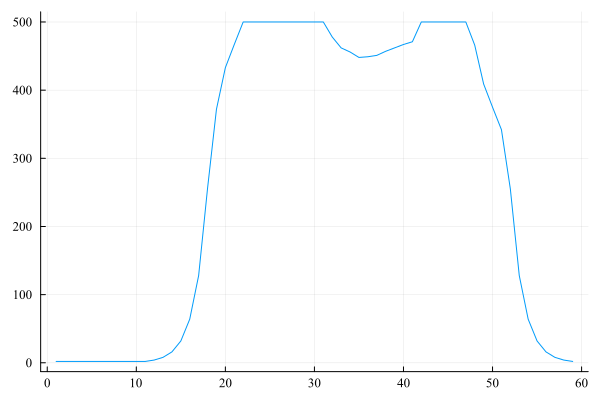

In [65]:
χ = [i for i in linkdims(mps)];
plot(χ,legend=false)

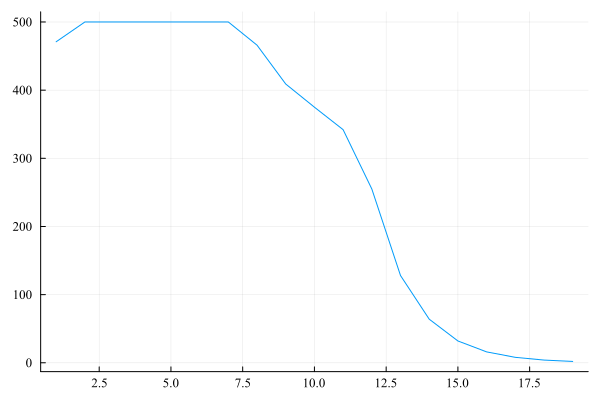

In [66]:
χ2 = [i for i in linkdims(I)];
plot(χ2,legend=false)

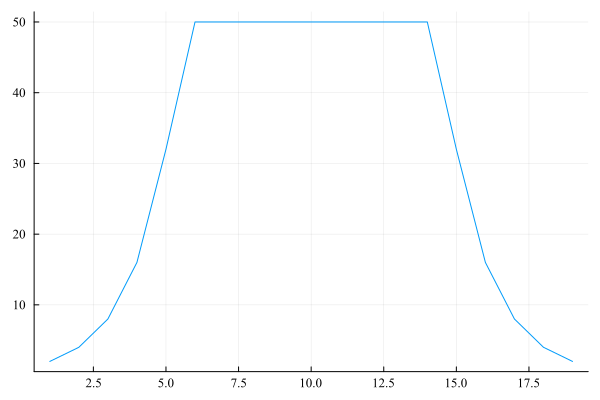

In [67]:
I2 = copy(I)
truncate!(I2, maxdim = 50)
χ3 = [i for i in linkdims(I2)];
plot(χ3,legend=false)

In [51]:
x1 = c2b(1/(2*E_max) + 1/2 ,L2)
x2 = c2b((1000 - 1)/(β_max) ,L3)
s = [x1; x2] 
#println(length(s))

evaluate(I2,s)

0.0001559092464735277 + 0.0050635562646424315im

**Test Code Powerpoint**

In [4]:
using ITensors
import TensorCrossInterpolation as TCI
using TCIITensorConversion
using QuanticsGrids
using Plots
using Plots
using LaTeXStrings
include("../../src/functions.jl")

# Set default font family (Times New Roman) and apply individual font sizes
default(fontfamily="Times New Roman")


I2 = h5open("mps_nF_n_E_beta_40_10_10.h5", "r") do file
    read(file, "MPS", MPS)
end
println("I2 uploaded")

# Define the function nF_exact
function nF_exact(β0, E)
    return 1 / (1 + exp(β0 * E))
end


L1 = 40 #for n
L2 = 10 #for E
L3 = 10
L = Int(L1+L2+L3)
β_max = 1000
E_max = 5


packages uploaded
------------------------------
functions uploaded
------------------------------


I2 uploaded


5

In [5]:


E_range = LinRange(-E_max,E_max,500)
β = 50



nFs = []
for E in E_range
    x1 = c2b(E/(2E_max) + 1/2 ,L2)
    x2 = c2b((β - 1)/(β_max) ,L3)
    s = [x1;x2]
    push!(nFs , evaluate(I2,s))
end

println("Done!")

Done!


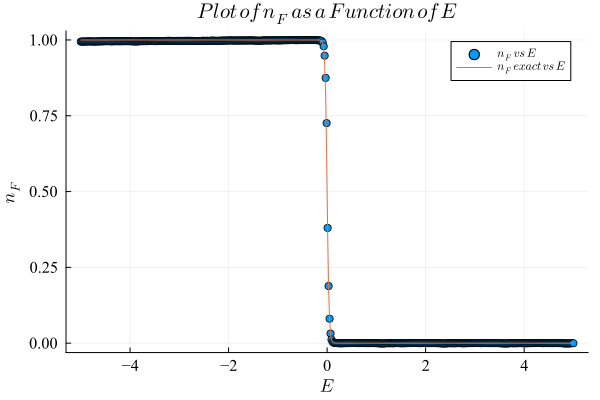

In [6]:
p = scatter(E_range, real.(nFs), label=L"n_F \, \textit{vs} \, E", xlabel=L"E", ylabel=L"n_F", 
    title=L"Plot \, of \, n_F \, \textit{as} \, a \, \textit{Function} \, of \, E", 
    legend=:topright, grid=true,
    titlefont=14, guidefont=12, tickfont=10)  # Set fonts for title, axis labels, and ticks

    # Overlay the exact function plot
    plot!(E_range, nF_exact.(β, E_range), label=L"n_F \, \textit{exact} \, \textit{vs} \, E", 
        legend=:topright,
        titlefont=14, guidefont=12, tickfont=10)
display(p)